## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from spotoptim import SpotOptim
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 6)
print("✓ Setup complete!")

✓ Setup complete!


## 2. The Exploration-Exploitation Dilemma

### The Challenge

**Exploitation**: Focus on regions with low predicted values  
- Pro: Quickly improve current best  
- Con: May miss better regions

**Exploration**: Focus on regions with high uncertainty  
- Pro: Discover new promising areas  
- Con: May waste evaluations

### Visual Example

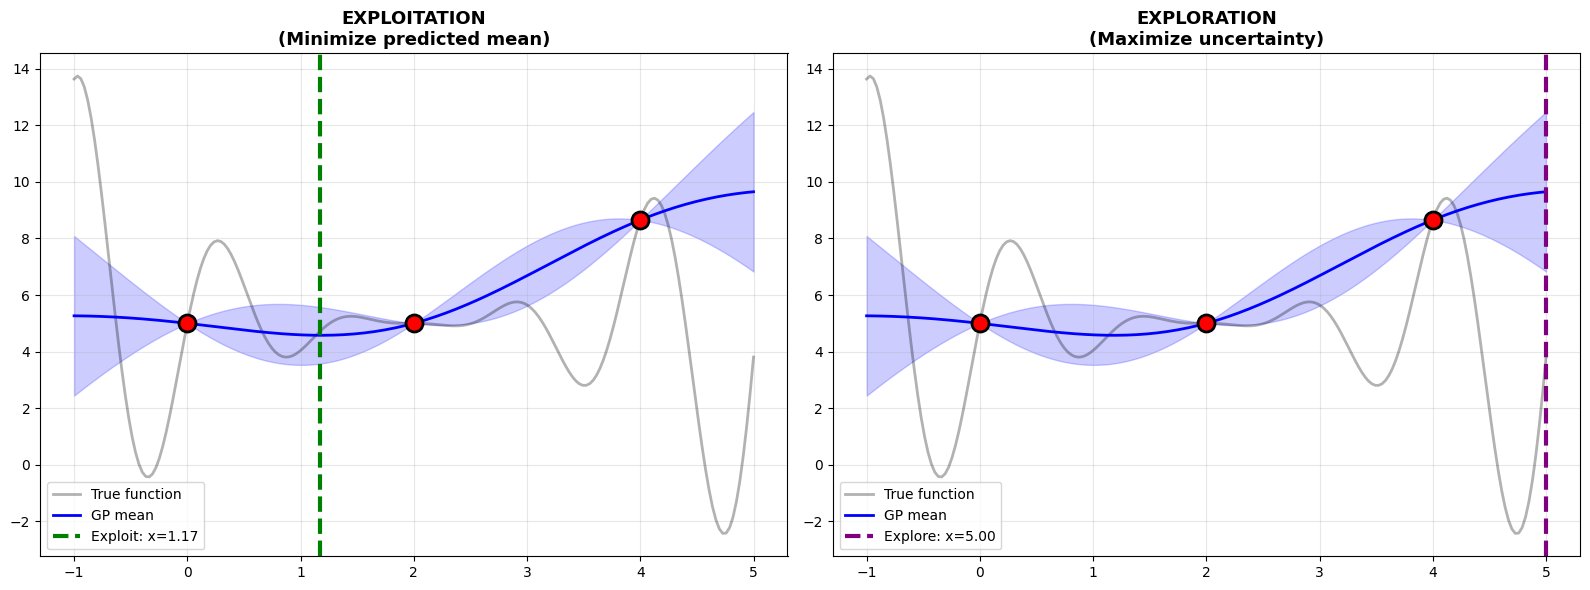

Pure exploitation: x = 1.17 (near known minimum)
Pure exploration:  x = 5.00 (maximum uncertainty)

💡 We need to balance both strategies!


In [2]:
def simple_1d_function(x):
    return (x - 2)**2 * np.sin(5*x) + 5

# Training data
X_train = np.array([0, 2, 4]).reshape(-1, 1)
y_train = simple_1d_function(X_train.ravel())

# Fit GP
kernel = ConstantKernel(1.0) * Matern(nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_train, y_train)

# Predict
X_plot = np.linspace(-1, 5, 200).reshape(-1, 1)
y_true = simple_1d_function(X_plot.ravel())
y_pred, y_std = gp.predict(X_plot, return_std=True)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Exploitation
ax1.plot(X_plot, y_true, 'k-', linewidth=2, alpha=0.3, label='True function')
ax1.plot(X_plot, y_pred, 'b-', linewidth=2, label='GP mean')
ax1.fill_between(X_plot.ravel(), y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.2, color='blue')
ax1.scatter(X_train, y_train, s=150, c='red', zorder=5, edgecolors='black', linewidth=2)
exploit_x = X_plot[np.argmin(y_pred)]
ax1.axvline(exploit_x, color='green', linewidth=3, linestyle='--', label=f'Exploit: x={exploit_x[0]:.2f}')
ax1.set_title('EXPLOITATION\n(Minimize predicted mean)', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Exploration
ax2.plot(X_plot, y_true, 'k-', linewidth=2, alpha=0.3, label='True function')
ax2.plot(X_plot, y_pred, 'b-', linewidth=2, label='GP mean')
ax2.fill_between(X_plot.ravel(), y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.2, color='blue')
ax2.scatter(X_train, y_train, s=150, c='red', zorder=5, edgecolors='black', linewidth=2)
explore_x = X_plot[np.argmax(y_std)]
ax2.axvline(explore_x, color='purple', linewidth=3, linestyle='--', label=f'Explore: x={explore_x[0]:.2f}')
ax2.set_title('EXPLORATION\n(Maximize uncertainty)', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Pure exploitation: x = {exploit_x[0]:.2f} (near known minimum)")
print(f"Pure exploration:  x = {explore_x[0]:.2f} (maximum uncertainty)")
print(f"\n💡 We need to balance both strategies!")

## 3. Acquisition Functions

**Acquisition functions** balance exploration and exploitation mathematically.

### 3.1 Common Acquisition Functions

Given GP prediction $\mu(x)$ and uncertainty $\sigma(x)$:

**1. Expected Improvement (EI)**
$$\text{EI}(x) = \mathbb{E}[\max(f_{\text{best}} - f(x), 0)]$$
$$= (f_{\text{best}} - \mu(x))\Phi(Z) + \sigma(x)\phi(Z)$$
where $Z = \frac{f_{\text{best}} - \mu(x)}{\sigma(x)}$

**2. Probability of Improvement (PI)**
$$\text{PI}(x) = \Phi\left(\frac{f_{\text{best}} - \mu(x)}{\sigma(x)}\right)$$

**3. Lower Confidence Bound (LCB)**
$$\text{LCB}(x) = \mu(x) - \kappa \sigma(x)$$

where $\kappa$ controls exploration.

### 3.2 Visualizing Acquisition Functions

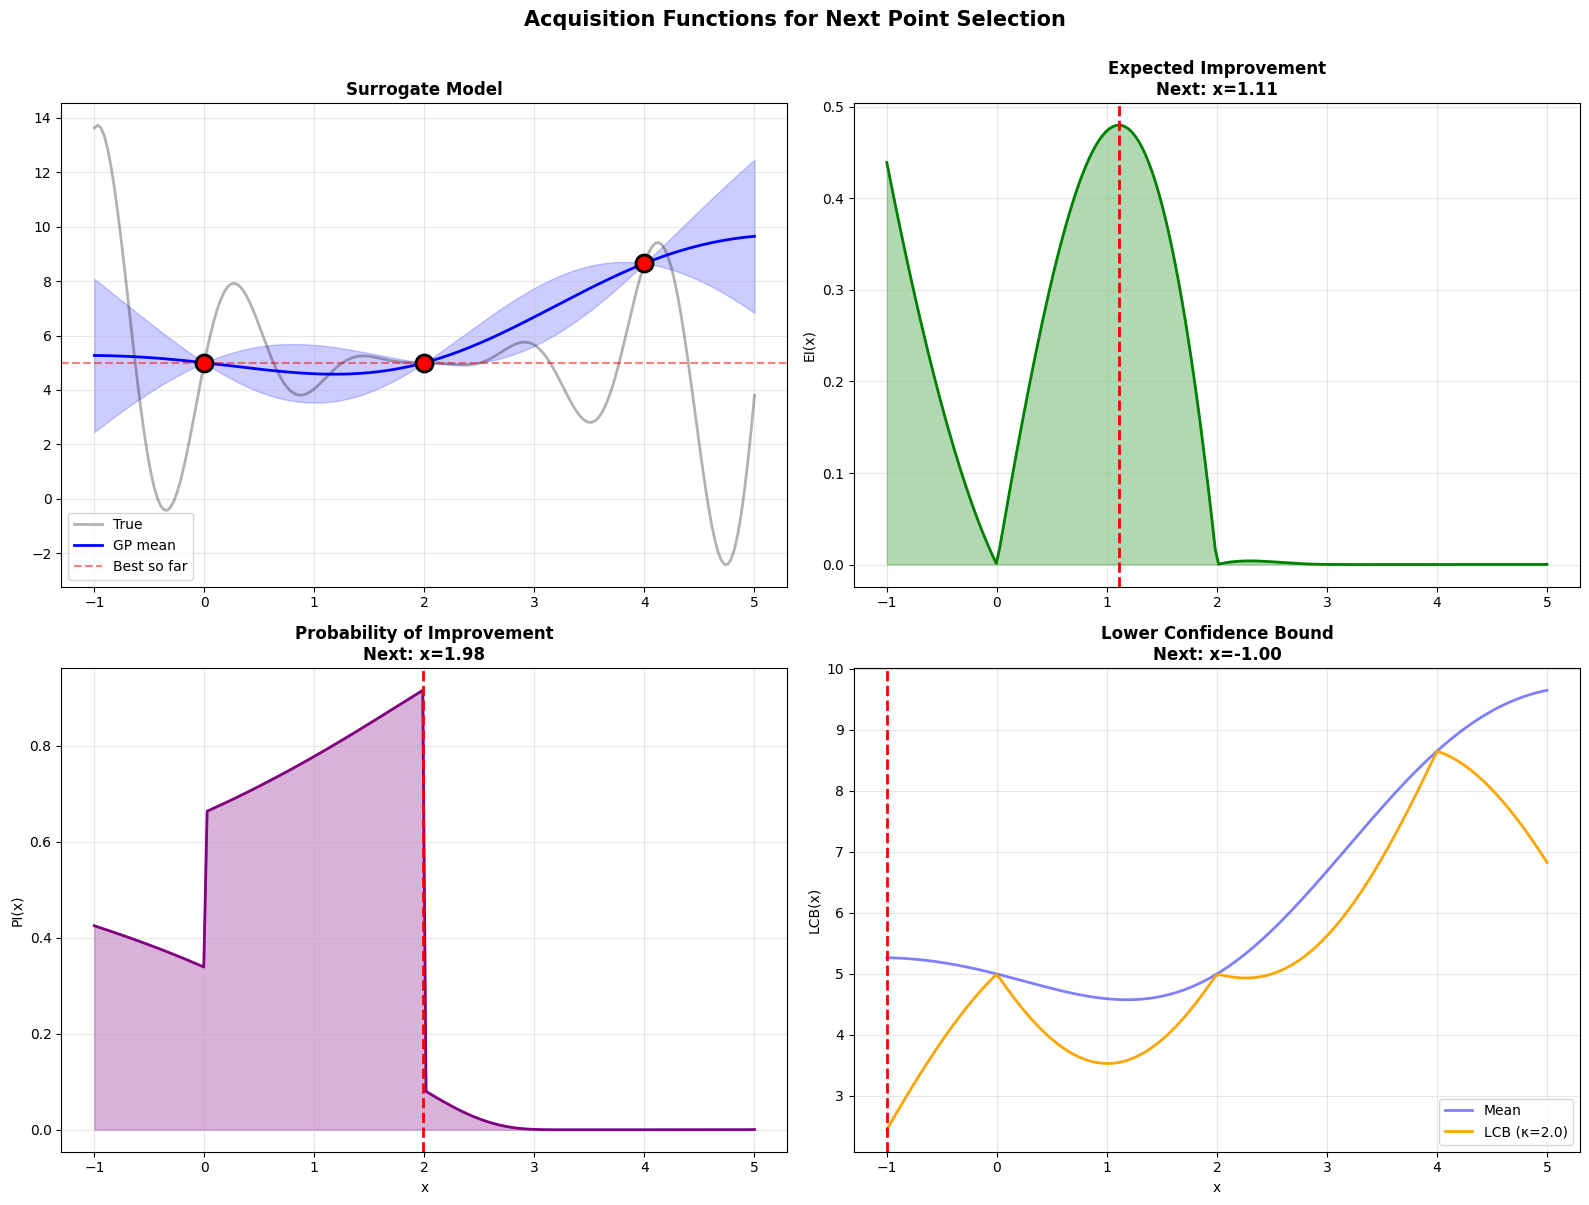


🎯 Key Insights:
- EI balances improvement potential and uncertainty
- PI focuses on probability of any improvement
- LCB with high κ explores more, low κ exploits more
- All suggest different next points!


In [3]:
# Compute acquisition functions
f_best = np.min(y_train)

# Expected Improvement
Z = (f_best - y_pred) / (y_std + 1e-9)
ei = (f_best - y_pred) * norm.cdf(Z) + y_std * norm.pdf(Z)
ei[y_std < 1e-9] = 0

# Probability of Improvement
pi = norm.cdf(Z)

# Lower Confidence Bound
kappa = 2.0
lcb = y_pred - kappa * y_std

# Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# GP with data
axes[0, 0].plot(X_plot, y_true, 'k-', linewidth=2, alpha=0.3, label='True')
axes[0, 0].plot(X_plot, y_pred, 'b-', linewidth=2, label='GP mean')
axes[0, 0].fill_between(X_plot.ravel(), y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.2, color='blue')
axes[0, 0].scatter(X_train, y_train, s=150, c='red', zorder=5, edgecolors='black', linewidth=2)
axes[0, 0].axhline(f_best, color='red', linestyle='--', alpha=0.5, label=f'Best so far')
axes[0, 0].set_title('Surrogate Model', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Expected Improvement
axes[0, 1].plot(X_plot, ei, 'g-', linewidth=2)
axes[0, 1].fill_between(X_plot.ravel(), 0, ei, alpha=0.3, color='green')
ei_max_idx = np.argmax(ei)
axes[0, 1].axvline(X_plot[ei_max_idx], color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title(f'Expected Improvement\nNext: x={X_plot[ei_max_idx, 0]:.2f}', fontweight='bold')
axes[0, 1].set_ylabel('EI(x)')
axes[0, 1].grid(True, alpha=0.3)

# Probability of Improvement
axes[1, 0].plot(X_plot, pi, 'purple', linewidth=2)
axes[1, 0].fill_between(X_plot.ravel(), 0, pi, alpha=0.3, color='purple')
pi_max_idx = np.argmax(pi)
axes[1, 0].axvline(X_plot[pi_max_idx], color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title(f'Probability of Improvement\nNext: x={X_plot[pi_max_idx, 0]:.2f}', fontweight='bold')
axes[1, 0].set_ylabel('PI(x)')
axes[1, 0].set_xlabel('x')
axes[1, 0].grid(True, alpha=0.3)

# Lower Confidence Bound
axes[1, 1].plot(X_plot, y_pred, 'b-', linewidth=2, alpha=0.5, label='Mean')
axes[1, 1].plot(X_plot, lcb, 'orange', linewidth=2, label=f'LCB (κ={kappa})')
lcb_min_idx = np.argmin(lcb)
axes[1, 1].axvline(X_plot[lcb_min_idx], color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title(f'Lower Confidence Bound\nNext: x={X_plot[lcb_min_idx, 0]:.2f}', fontweight='bold')
axes[1, 1].set_ylabel('LCB(x)')
axes[1, 1].set_xlabel('x')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Acquisition Functions for Next Point Selection', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n🎯 Key Insights:")
print("- EI balances improvement potential and uncertainty")
print("- PI focuses on probability of any improvement")
print("- LCB with high κ explores more, low κ exploits more")
print("- All suggest different next points!")

## 4. SpotOptim's Acquisition Function

SpotOptim uses the `_acquisition_function()` method with configurable strategies.

### 4.1 Available Strategies

In [4]:
def branin(X):
    X = np.atleast_2d(X)
    x1, x2 = X[:, 0], X[:, 1]
    return (x2 - 5.1/(4*np.pi**2)*x1**2 + 5/np.pi*x1 - 6)**2 + 10*(1-1/(8*np.pi))*np.cos(x1) + 10

# Create optimizers with different acquisition functions
acquisitions = ['ei', 'pi', 'y']

for acq in acquisitions:
    opt = SpotOptim(
        fun=branin,
        bounds=[(-5, 10), (0, 15)],
        n_initial=10,
        acquisition=acq,
        seed=42
    )
    
    # Setup
    X0 = opt._set_initial_design()
    y0 = branin(X0)
    opt._fit_surrogate(X0, y0)
    opt.X_ = X0
    opt.y_ = y0
    
    # Test acquisition function
    x_test = np.array([2.5, 7.5])
    acq_value = opt._acquisition_function(x_test)
    
    print(f"{acq.upper():3s}: acquisition value at {x_test} = {acq_value:.6f}")

print("\n💡 SpotOptim acquisition parameter:")
print("  'ei' - Expected Improvement (default, recommended)")
print("  'pi' - Probability of Improvement")
print("  'y'  - Pure exploitation (predicted mean)")

EI : acquisition value at [2.5 7.5] = -0.025136
PI : acquisition value at [2.5 7.5] = -0.005464
Y  : acquisition value at [2.5 7.5] = 40.464179

💡 SpotOptim acquisition parameter:
  'ei' - Expected Improvement (default, recommended)
  'pi' - Probability of Improvement
  'y'  - Pure exploitation (predicted mean)
Y  : acquisition value at [2.5 7.5] = 40.464179

💡 SpotOptim acquisition parameter:
  'ei' - Expected Improvement (default, recommended)
  'pi' - Probability of Improvement
  'y'  - Pure exploitation (predicted mean)


## 5. SpotOptim's `_suggest_next_point()` Method

This method optimizes the acquisition function to find the next evaluation point.

In [5]:
# Create optimizer
opt = SpotOptim(
    fun=branin,
    bounds=[(-5, 10), (0, 15)],
    n_initial=15,
    acquisition='ei',
    seed=42
)

# Initial design
X0 = opt._set_initial_design()
y0 = branin(X0)
opt._fit_surrogate(X0, y0)
opt.X_ = X0
opt.y_ = y0

# Suggest next point
print("Suggesting next point using EI acquisition...")
x_next = opt._suggest_next_point()

print(f"\n✓ Next point suggested: {x_next}")
print(f"  Expected value at x_next: {opt.surrogate.predict([x_next])[0]:.4f}")
print(f"  Current best value: {np.min(y0):.4f}")

# Evaluate
y_next = branin(x_next.reshape(1, -1))[0]
print(f"  Actual value at x_next: {y_next:.4f}")

if y_next < np.min(y0):
    print(f"\n🎉 Improvement found! New best: {y_next:.4f}")
else:
    print(f"\n📊 No improvement, but gained information")

Suggesting next point using EI acquisition...

✓ Next point suggested: [-0.1940024  6.7310789]
  Expected value at x_next: -25.0505
  Current best value: 0.5752
  Actual value at x_next: 19.5962

📊 No improvement, but gained information


## 6. Sequential Optimization Loop

Let's see the complete sequential optimization process.

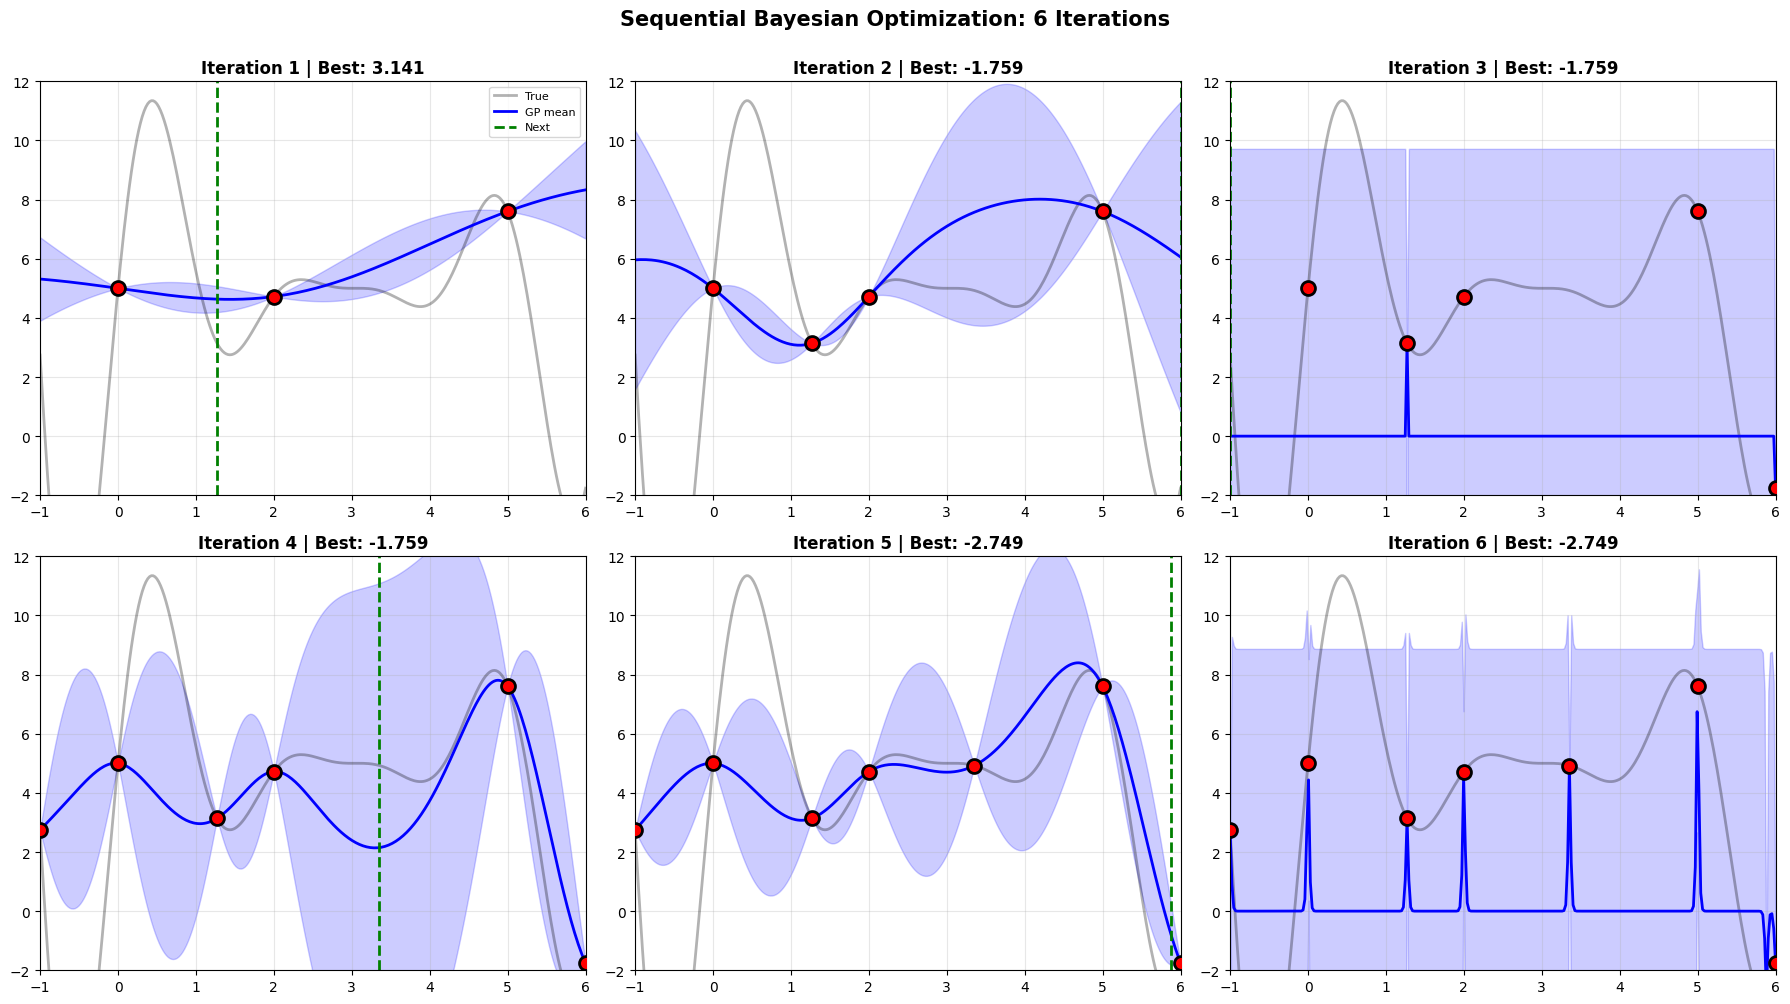


📈 Optimization Progress:
  Initial best: 4.7206
  Final best:   -2.7487
  True minimum: -7.6324

💡 Notice how the surrogate improves and converges to the minimum!


In [6]:
# Simple 1D example for visualization
def test_func_1d(x):
    return (x - 3)**2 * np.sin(3*x) + 5

# Initial setup
X_seq = np.array([0, 2, 5]).reshape(-1, 1)
y_seq = test_func_1d(X_seq.ravel())

# True function
X_true = np.linspace(-1, 6, 300).reshape(-1, 1)
y_true_seq = test_func_1d(X_true.ravel())

# Sequential iterations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for iter_num in range(6):
    ax = axes[iter_num]
    
    # Fit GP
    gp_seq = GaussianProcessRegressor(
        kernel=ConstantKernel(1.0) * Matern(nu=2.5),
        n_restarts_optimizer=10
    )
    gp_seq.fit(X_seq, y_seq)
    
    # Predict
    y_pred_seq, y_std_seq = gp_seq.predict(X_true, return_std=True)
    
    # Compute EI
    f_best_seq = np.min(y_seq)
    Z_seq = (f_best_seq - y_pred_seq) / (y_std_seq + 1e-9)
    ei_seq = (f_best_seq - y_pred_seq) * norm.cdf(Z_seq) + y_std_seq * norm.pdf(Z_seq)
    ei_seq[y_std_seq < 1e-9] = 0
    
    # Plot
    ax.plot(X_true, y_true_seq, 'k-', linewidth=2, alpha=0.3, label='True')
    ax.plot(X_true, y_pred_seq, 'b-', linewidth=2, label='GP mean')
    ax.fill_between(X_true.ravel(), y_pred_seq - 2*y_std_seq, y_pred_seq + 2*y_std_seq, 
                     alpha=0.2, color='blue')
    ax.scatter(X_seq, y_seq, s=100, c='red', zorder=5, edgecolors='black', linewidth=2)
    
    if iter_num < 5:  # Don't suggest for last iteration
        # Find next point
        x_next_seq = X_true[np.argmax(ei_seq)]
        ax.axvline(x_next_seq, color='green', linestyle='--', linewidth=2, label='Next')
        
        # Evaluate and add to dataset
        y_next_seq = test_func_1d(x_next_seq)
        X_seq = np.vstack([X_seq, x_next_seq.reshape(1, -1)])
        y_seq = np.append(y_seq, y_next_seq)
    
    ax.set_title(f'Iteration {iter_num+1} | Best: {np.min(y_seq):.3f}', fontweight='bold')
    ax.set_xlim(-1, 6)
    ax.set_ylim(-2, 12)
    if iter_num == 0:
        ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Sequential Bayesian Optimization: 6 Iterations', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\n📈 Optimization Progress:")
print(f"  Initial best: {test_func_1d(np.array([0, 2, 5])).min():.4f}")
print(f"  Final best:   {np.min(y_seq):.4f}")
print(f"  True minimum: {y_true_seq.min():.4f}")
print(f"\n💡 Notice how the surrogate improves and converges to the minimum!")

## 7. Complete Optimization with SpotOptim

Now let's see the full optimization workflow.

In [7]:
# Run complete optimization
opt_full = SpotOptim(
    fun=branin,
    bounds=[(-5, 10), (0, 15)],
    n_initial=10,
    max_iter=30,
    acquisition='ei',
    verbose=True,
    seed=42
)

result = opt_full.optimize()

print(f"\n" + "="*60)
print(f"OPTIMIZATION RESULTS")
print(f"="*60)
print(f"Best point found: {result.x}")
print(f"Best value: {result.fun:.6f}")
print(f"Global optimum: ~0.397887")
print(f"Total evaluations: {result.nfev}")
print(f"Sequential iterations: {result.nit}")
print(f"Success: {result.success}")
print(f"="*60)

TensorBoard logging disabled
Initial best: f(x) = 3.737228
Iteration 1: f(x) = 56.830615
Iteration 2: f(x) = 45.895267
Iteration 3: New best f(x) = 2.683608
Iteration 4: f(x) = 10.960889
Iteration 5: New best f(x) = 2.141944
Iteration 6: f(x) = 17.223877
Iteration 7: New best f(x) = 1.787459
Iteration 4: f(x) = 10.960889
Iteration 5: New best f(x) = 2.141944
Iteration 6: f(x) = 17.223877
Iteration 7: New best f(x) = 1.787459
Iteration 8: f(x) = 2.018122
Iteration 9: New best f(x) = 1.247150
Iteration 10: f(x) = 1.667847
Iteration 8: f(x) = 2.018122
Iteration 9: New best f(x) = 1.247150
Iteration 10: f(x) = 1.667847
Iteration 11: f(x) = 17.508300
Iteration 12: f(x) = 7.216982
Iteration 13: f(x) = 1.537939
Iteration 11: f(x) = 17.508300
Iteration 12: f(x) = 7.216982
Iteration 13: f(x) = 1.537939
Iteration 14: f(x) = 308.129096
Iteration 15: f(x) = 145.872191
Iteration 16: f(x) = 20.113380
Iteration 14: f(x) = 308.129096
Iteration 15: f(x) = 145.872191
Iteration 16: f(x) = 20.113380
Itera

## 8. Key Takeaways

### Exploration vs Exploitation

✅ **Balance is Critical**
- Pure exploitation: Gets stuck in local minima
- Pure exploration: Wastes evaluations
- Acquisition functions balance both

✅ **Acquisition Functions**
- **EI (Expected Improvement)**: Best default choice
- **PI (Probability of Improvement)**: More exploitative
- **LCB/UCB**: Exploration controlled by κ

✅ **SpotOptim Workflow**
```python
1. _fit_surrogate()         # Train on current data
2. _suggest_next_point()    # Optimize acquisition function
3. Evaluate function        # Get true value
4. Update dataset           # Add new point
5. Repeat until converged
```

✅ **Best Practices**
- Use EI for most problems
- More initial samples → Better initial surrogate
- Sequential optimization naturally balances explore/exploit
- Uncertainty guides exploration

---

**Previous:** [Tutorial 2 - Constructing a Surrogate](02_constructing_surrogate.ipynb)  
**Next:** [Tutorial 4 - Visualization Techniques](04_visualization.ipynb)